## Toy data set

Let's train a network to classify ice hockey match scores to match results. We'll have the teams' goal amounts as the input and one-hot encoding of HOME_WIN, DRAW and AWAY_WIN as output. For example, for a match that ends 6–4, we would have [6, 4] as the input and [1, 0, 0] as output, because it's a win for the home team.

In [1]:
training_data = [
    ([5, 4], [1, 0, 0]),
    ([1, 4], [0, 0, 1]),
    ([2, 4], [0, 0, 1]),
    ([0, 0], [0, 1, 0]),
    ([2, 2], [0, 1, 0]),
    ([7, 1], [1, 0, 0]),
    ([1, 0], [1, 0, 0]),
    ([1, 2], [0, 0, 1])
]

test_data = [
    ([8, 2], [1, 0, 0]),
    ([7, 7], [0, 1, 0]),
    ([1, 3], [0, 0, 1]),
    ([3, 3], [0, 1, 0])
]

training_inputs, training_labels = zip(*training_data)
test_inputs, test_labels = zip(*test_data)

Let's plot the data.

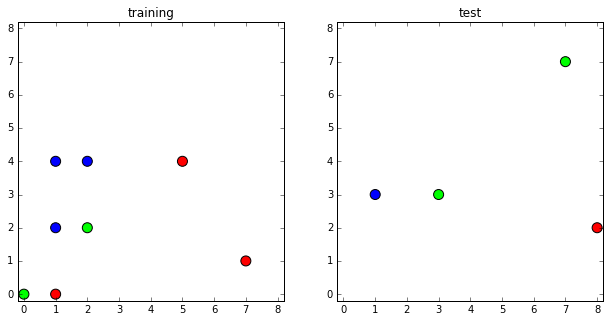

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

p, (training_plot, test_plot) = plt.subplots(
        1, 2, figsize=(10.5,5), 
        subplot_kw={'xlim': [-0.2, 8.2], 'ylim': [-0.2, 8.2]})

x, y = zip(*training_inputs)
training_plot.scatter(x, y, c=training_labels, s=100)
training_plot.set_title("training")

x, y = zip(*test_inputs)
test_plot.scatter(x, y, c=test_labels, s=100)
test_plot.set_title("test")

## Softmax classifier

We are going to use a softmax classifier to solve this task. Here are two ways to visualize what we will build:

![](images/softmax for toy problem.png)

Explain these things:

- Theory of softmax classification
	- Draw the softmax graph on whiteboard
	- Explain linear module
	- Explain softmax module
- Theory of optimization
	- We try to find weights in the linear module that solve the problem
	- We need to define what’s a good solution: cost function
	- We need to somehow update the weights so that they minimize the cost function: the optimizer
	- Draw a parameter space gradient-descent picture on the whiteboard
	- Draw gradient arrows and descent path but don’t go into details of differentiation
- How TensorFlow works
	- It describes and runs computation graphs
	- Why graphs?
		- So we can compile the same solution for different processors and architectures: CPU, GPU, ARM…
		- So we can use Python to construct the graph and C++ to run it
		- So we can automatically calculate the gradients
	- We first build the graph: default_graph
	- And then run it: Session.run
- Introduce Tensors
	- The graph is based on Tensors: multi-dimensional arrays. Most operations apply to all of the elements of the array at the same time.

## Build the model with TensorFlow

In [3]:
import tensorflow as tf

# Clear the graph because we might run this
# cell in Jupyter many times, and we don't
# want multiple copies of the graph.
tf.python.framework.ops.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, 2], name="inputs")
expected_outputs = tf.placeholder(tf.float32, [None, 3], name="weights")
weights = tf.Variable(tf.zeros([2, 3], tf.float32), name="weights")
biases = tf.Variable(tf.zeros([3]), tf.float32, name="biases")

with tf.name_scope("linear_softmax"):
    outputs = tf.nn.softmax(tf.matmul(inputs, weights) + biases)

## What does the graph look like?

In [4]:
with tf.Session() as session:
    writer = tf.train.SummaryWriter("../logs/softmax", graph_def=session.graph_def)
    writer.close()
    print "Done!"

Done!


Something like this:

![](images/softmax graph in tensorboard.png)

## Calculate accuracy

Explain what accuracy is for.

Explain on whiteboard how accuracy works.

In [5]:
labels = tf.argmax(outputs, 1)
expected_labels = tf.argmax(expected_outputs, 1)
correct_prediction = tf.equal(labels, expected_labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Add gradient descent to the graph

- Remind how gradient descent works.
- Explain on whiteboard how cross entropy works.

In [6]:
with tf.name_scope("cross_entropy"):
    cross_entropy = -tf.reduce_sum(expected_outputs*tf.log(outputs))

with tf.name_scope("train_step"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    train_step = optimizer.minimize(cross_entropy)

## Initialize variables

This is part of the graph too!

In [7]:
initialize = tf.initialize_all_variables()

## Train and test accuracy

In [8]:
session = tf.Session()
session.run(initialize)
for step in xrange(1000):
    session.run(train_step, {
            inputs: training_inputs,
            expected_outputs: training_labels
        })

    if step % 100 == 0:
        print
        print session.run(accuracy, {
                inputs: training_inputs,
                expected_outputs: training_labels}),
    
    if step % 10 == 0:
        print ".",

    
print
print "Training error: %f" % session.run(accuracy, {
        inputs: training_inputs,
        expected_outputs: training_labels})
print "Test error: %f" % session.run(accuracy, {
        inputs: test_inputs,
        expected_outputs: test_labels})

test_run_results = session.run(labels, {
        inputs: test_inputs
    })


0.75 . . . . . . . . . .
0.875 . . . . . . . . . .
1.0 . . . . . . . . . .
1.0 . . . . . . . . . .
1.0 . . . . . . . . . .
1.0 . . . . . . . . . .
1.0 . . . . . . . . . .
1.0 . . . . . . . . . .
1.0 . . . . . . . . . .
1.0 . . . . . . . . . .
Training error: 1.000000
Test error: 0.750000


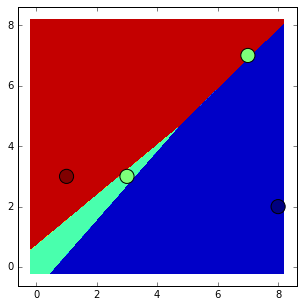

In [10]:
import numpy as np

plt.figure(figsize=(5,5))

y_min, y_max = x_min, x_max = [-0.2, 8.2]
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

def model(inputs_):
    return session.run(labels, {inputs: inputs_})

# Plot contours
Z = model(np.c_[xx.ravel(), yy.ravel()]) 
c = plt.contourf(xx, yy, Z.reshape(xx.shape))

# Plot test data
x, y = zip(*test_inputs)
z = np.argmax(test_labels, 1)
plt.scatter(x, y, c=z/30.0, s=200)


## About decision boundaries

Note that the decision boundaries are linear!